In [327]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

In [389]:
ztf_central_wavelengths = {
    '1': 4813.9, #g
    '2': 6421.8, #r
}

In [352]:
lcs = pd.read_csv('../data/real/real_lcs_clean.csv')
lc = lcs[lcs.IAUID=='SN2019wka']
lc

,Unnamed: 0,jd,magpsf,sigmapsf,magzpsci,fid,isdiffpos,ZTFID,IAUID,mjd
71841,267521,2458831.748,17.070,0.023,27.5,1,t,NaN,SN2019wka,58831.248
71842,267522,2458833.689,16.956,0.011,27.5,1,t,NaN,SN2019wka,58833.189
71843,267523,2458833.769,17.106,0.014,27.5,2,t,NaN,SN2019wka,58833.269
71844,267524,2458837.715,16.913,0.010,27.5,1,t,NaN,SN2019wka,58837.215
71845,267525,2458837.734,16.993,0.012,27.5,2,t,NaN,SN2019wka,58837.234
...,...,...,...,...,...,...,...,...,...,...
71897,267577,2458903.644,20.056,0.148,27.5,1,t,NaN,SN2019wka,58903.144
71898,267578,2458903.666,19.489,0.115,27.5,2,t,NaN,SN2019wka,58903.166
71899,267579,2458905.617,19.595,0.162,27.5,2,t,NaN,SN2019wka,58905.117
71900,267580,2458905.628,20.213,0.242,27.5,1,t,NaN,SN2019wka,58905.128


In [431]:
def fit_gp(times, magnitudes, errors, bands):
    wavelengths=np.array([ztf_central_wavelengths[str(b)] for b in bands])
    # Estimate initial scale using signal-to-noise ratio
    signal_to_noises = 1.0 / errors  # Assuming uncertainties in magnitudes
    initial_scale = np.abs(magnitudes[signal_to_noises.idxmax()])

    # Define Matern kernel for time
    matern_time = Matern(length_scale=20, nu=1.5)

    # Define Matern kernel for wavelength (fixing the length scale)
    matern_wavelength = Matern(length_scale=1000.0, nu=1.5,length_scale_bounds=(1e-2, 1e9))

    # Combine kernels into a product kernel
    kernel = initial_scale**2 * matern_time * matern_wavelength

    gp = GaussianProcessRegressor(kernel=kernel, alpha=errors**2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=10)

    gp.fit(np.vstack([times, wavelengths]).T, magnitudes)

    return gp.predict

In [432]:
def predict(lc):
    times = lc.mjd
    magnitudes = lc.magpsf
    errors=lc.sigmapsf
    bands=lc.fid
    gp = fit_gp(times,magnitudes,errors,bands)
    days = np.floor(times.max()-times.min())
    pred_times = np.arange(times.min(), times.max() + 1, 1)
    wavelengths=np.ones(len(pred_times))
    predictions_band1, prediction_variances_band1 = gp(np.vstack([pred_times, wavelengths*ztf_central_wavelengths['1']]).T, return_std=True)
    predictions_band2, prediction_variances_band2 = gp(np.vstack([pred_times, wavelengths*ztf_central_wavelengths['2']]).T, return_std=True)
    return predictions_band1, prediction_variances_band1,predictions_band2, prediction_variances_band2, pred_times

In [433]:
def plot(lc,
         predictions_band1, predictions_variances_band1,
         predictions_band2, predictions_variances_band2, 
         pred_times
        ):
    lc_r=lc[lc.fid==2]
    lc_g=lc[lc.fid==1]
    plt.gca().invert_yaxis()
    plt.scatter(lc_r.mjd,lc_r.magpsf,color='red')
    plt.scatter(lc_g.mjd,lc_g.magpsf,color='green')
    plt.plot(pred_times,predictions_band2,color='red')
    plt.plot(pred_times,predictions_band1,color='green')

    plt.fill_between(pred_times, predictions_band2 - prediction_variances_band2, predictions_band2 + prediction_variances_band2, color='red', alpha=0.2)

    plt.fill_between(pred_times, predictions_band1 - prediction_variances_band1, predictions_band1 + prediction_variances_band1, color='green', alpha=0.2)

In [531]:
lcIa = lcs[lcs.IAUID=='AT2020yla']
lcIbc = lcs[lcs.IAUID=='SN2018isl']
lcII = lcs[lcs.IAUID=='SN2018elp']
lcSL = lcs[lcs.IAUID=='SN2023vco']

In [462]:
pgIag,pgIagv,pgIar,pgIarv,ptIa = predict(lcIa)

/home/ai/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [532]:
pgIbcg,pgIbcgv,pgIbcr,pgIbcrv,ptIbc = predict(lcIbc)

/home/ai/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [468]:
pgIIg,pgIIgv,pgIIr,pgIIrv,ptII = predict(lcII)

In [465]:
pgSLg,pgSLgv,pgSLr,pgSLrv,ptSL = predict(lcSL)

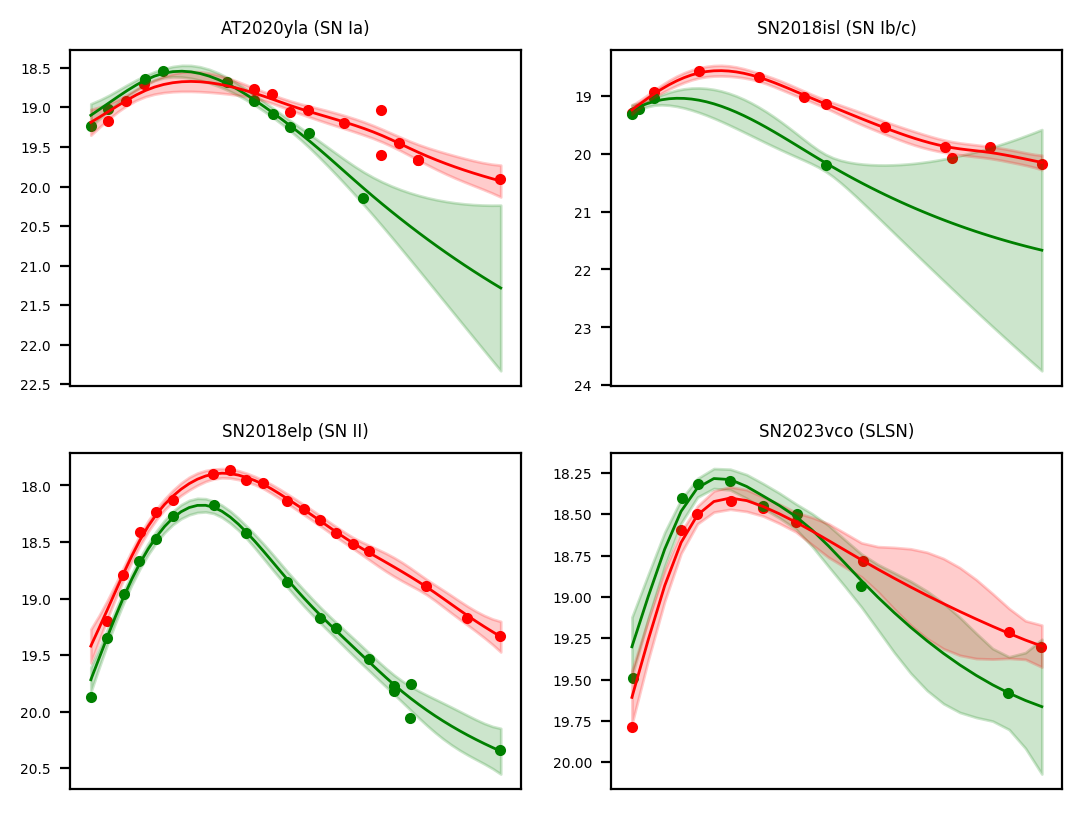

In [549]:
fig, axs = plt.subplots(2, 2,dpi=200)
plt.rc('ytick', labelsize=5) 
axs[0,0].invert_yaxis()
axs[0, 0].scatter(lcIa[lcIa.fid==2].mjd,lcIa[lcIa.fid==2].magpsf,color='red',marker='.')
axs[0, 0].scatter(lcIa[lcIa.fid==1].mjd,lcIa[lcIa.fid==1].magpsf,color='green',marker='.')
axs[0, 0].plot(ptIa,pgIag,color='green',linewidth=1)
axs[0, 0].plot(ptIa,pgIar,color='red',linewidth=1)
axs[0, 0].fill_between(ptIa,pgIag-pgIagv,pgIag+pgIagv,color='green',alpha=0.2)
axs[0, 0].fill_between(ptIa,pgIar-pgIarv,pgIar+pgIarv,color='red',alpha=0.2)

axs[0,1].invert_yaxis()
axs[0, 1].scatter(lcIbc[lcIbc.fid==2].mjd,lcIbc[lcIbc.fid==2].magpsf,color='red',marker='.')
axs[0, 1].scatter(lcIbc[lcIbc.fid==1].mjd,lcIbc[lcIbc.fid==1].magpsf,color='green',marker='.')
axs[0, 1].plot(ptIbc,pgIbcg,color='green',linewidth=1)
axs[0, 1].plot(ptIbc,pgIbcr,color='red',linewidth=1)
axs[0, 1].fill_between(ptIbc,pgIbcg-pgIbcgv,pgIbcg+pgIbcgv,color='green',alpha=0.2)
axs[0, 1].fill_between(ptIbc,pgIbcr-pgIbcrv,pgIbcr+pgIbcrv,color='red',alpha=0.2)

axs[1,0].invert_yaxis()
axs[1, 0].scatter(lcII[lcII.fid==2].mjd,lcII[lcII.fid==2].magpsf,color='red',marker='.')
axs[1, 0].scatter(lcII[lcII.fid==1].mjd,lcII[lcII.fid==1].magpsf,color='green',marker='.')
axs[1, 0].plot(ptII,pgIIg,color='green',linewidth=1)
axs[1, 0].plot(ptII,pgIIr,color='red',linewidth=1)
axs[1, 0].fill_between(ptII,pgIIg-pgIIgv,pgIIg+pgIIgv,color='green',alpha=0.2)
axs[1, 0].fill_between(ptII,pgIIr-pgIIrv,pgIIr+pgIIrv,color='red',alpha=0.2)

axs[1, 1].invert_yaxis()
axs[1, 1].scatter(lcSL[lcSL.fid==2].mjd,lcSL[lcSL.fid==2].magpsf,color='red',marker='.')
axs[1, 1].scatter(lcSL[lcSL.fid==1].mjd,lcSL[lcSL.fid==1].magpsf,color='green',marker='.')
axs[1, 1].plot(ptSL,pgSLg,color='green',linewidth=1)
axs[1, 1].plot(ptSL,pgSLr,color='red',linewidth=1)
axs[1, 1].fill_between(ptSL,pgSLg-pgSLgv,pgSLg+pgSLgv,color='green',alpha=0.2)
axs[1, 1].fill_between(ptSL,pgSLr-pgSLrv,pgSLr+pgSLrv,color='red',alpha=0.2)

axs[0, 0].set_title('AT2020yla (SN Ia)',size=6)
axs[0, 1].set_title('SN2018isl (SN Ib/c)',size=6)
axs[1, 0].set_title('SN2018elp (SN II)',size=6)
axs[1, 1].set_title('SN2023vco (SLSN)',size=6)

    # for ax in axs.flat:
        # ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set_xticks([])
#     ax.label_outer()

In [550]:
fig.savefig('gp_plot.png')